## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 必要なライブラリのインストール

In [ ]:
!pip install icrawler
!pip install tensorflow

## 画像スクレイピング

In [35]:
from icrawler.builtin import BingImageCrawler

labels =["basketball", "tennisball", "golfball"]
for label in labels:
  path = "/content/drive/MyDrive/GeekSalon/技術課題_画像分類/解答例/images/" + label
  crawler = BingImageCrawler(storage = {'root_dir' : path})
  crawler.crawl(keyword = label, max_num = 100)

ERROR:downloader:Response status code 403, file https://static.vecteezy.com/system/resources/previews/006/327/109/original/basketball-tournament-background-basketball-poster-wallpaper-free-vector.jpg


## スクレイピングした画像をtrainとtestフォルダに分割

In [36]:
import os
import shutil
import random

def split_train_test_data(source_dir, train_dir, test_dir, split_ratio=0.8):
    # ラベル付きのフォルダを取得
    labels = os.listdir(source_dir)
    for label in labels:
        label_dir = os.path.join(source_dir, label)
        if os.path.isdir(label_dir):
            # ラベルごとに画像ファイルのリストを取得
            images = os.listdir(label_dir)
            # 学習用とテスト用のフォルダを作成
            os.makedirs(os.path.join(train_dir, label), exist_ok=True)
            os.makedirs(os.path.join(test_dir, label), exist_ok=True)

            # 学習用とテスト用に分割
            random.shuffle(images)
            train_size = int(len(images) * split_ratio)
            train_images = images[:train_size]
            test_images = images[train_size:]
            print(f"{label}のtrainサイズは{train_size}")

            # 画像を移動
            for img in train_images:
                shutil.copy(os.path.join(label_dir, img), os.path.join(train_dir, label, img))
            for img in test_images:
                shutil.copy(os.path.join(label_dir, img), os.path.join(test_dir, label, img))

source_directory = '/content/drive/MyDrive/GeekSalon/技術課題_画像分類/解答例/images'
train_directory = '/content/drive/MyDrive/GeekSalon/技術課題_画像分類/解答例/train'
test_directory = '/content/drive/MyDrive/GeekSalon/技術課題_画像分類/解答例/test'
split_ratio = 0.8  # 学習用データの割合

split_train_test_data(source_directory, train_directory, test_directory, split_ratio)

basketballのtrainサイズは68
tennisballのtrainサイズは63
golfballのtrainサイズは70


## モデルの構築・学習・結果の可視化

### 条件の設定

In [48]:
import os
from gc import callbacks
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow
import numpy as np
import time
import matplotlib.pyplot as plt
from google.colab import files

img_width, img_height = 224, 224
data_train = "/content/drive/MyDrive/GeekSalon/技術課題_画像分類/解答例/train"
data_test = "/content/drive/MyDrive/GeekSalon/技術課題_画像分類/解答例/test"
classes = ["tennis","basketball","golf"]
nb_classes = len(classes)

### 画像のかさ増し

#### 画像かさ増しクラスのインスタンス化

In [39]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,
    fill_mode="constant",
    zca_epsilon=1e-06,
    rotation_range=20.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)

#### trainフォルダ内の画像を学習用と検証用に分割

In [40]:
# 学習用データのかさ増し
train_generator = datagen.flow_from_directory(
  data_train,
  target_size=(img_width, img_height),
  color_mode='rgb',
  class_mode='categorical',
  batch_size=32,
  subset='training',
  shuffle=True)

# 検証用データのかさ増し
validation_generator = datagen.flow_from_directory(
  data_train,
  target_size=(img_width, img_height),
  color_mode='rgb',
  class_mode='categorical',
  batch_size=32,
  subset='validation',
  shuffle=True)

Found 217 images belonging to 3 classes.
Found 23 images belonging to 3 classes.


### モデルの構築・学習

In [45]:
# tensorを定義
input_tensor = Input(shape=(img_width, img_height, 3))

# 既存モデルをロード
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# 全結合層を構築
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))  # ニューロン数を増やす
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_classes, activation='softmax'))

# VGG16と全結合層を結合
vgg_model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

# VGG16の15層目までの重みを固定
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# コンパイル。最適化関数はAdamが良い
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),  # 学習率を下げる
    metrics=['accuracy']
)

# 過学習の防止
callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# モデルの学習
history = vgg_model.fit(train_generator, epochs=20, verbose=1, validation_data=validation_generator, callbacks=[callback])

# モデルの保存
vgg_model.save("/content/drive/MyDrive/GeekSalon/技術課題_画像分類/解答例/ballCrastering.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_155']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.4111 - loss: 1.4897 - val_accuracy: 0.7391 - val_loss: 0.8362
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6268 - loss: 0.8680 - val_accuracy: 0.8696 - val_loss: 0.5684
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7937 - loss: 0.5682 - val_accuracy: 0.8261 - val_loss: 0.5533
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7474 - loss: 0.5731 - val_accuracy: 0.9130 - val_loss: 0.2138
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8898 - loss: 0.2915 - val_accuracy: 0.8696 - val_loss: 0.2495
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8860 - loss: 0.2601 - val_accuracy: 0.9565 - val_loss: 0.1181
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9446 - loss: 0.1172 - val_accuracy: 0.9565 - val_loss: 0.1485
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9738 - loss: 0.0824 - val_accuracy: 0.8696 - val_loss: 0.1838
Epoch 9/20
7/7 ━━━━━━━━━━━

### 学習の可視化

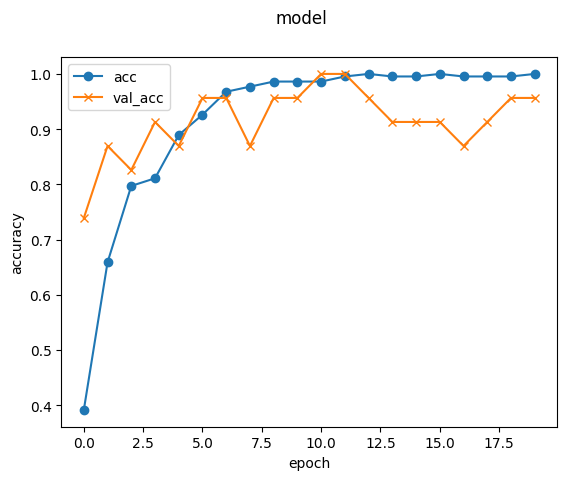

In [46]:
plt.plot(history.history['accuracy'], label='acc', ls='-', marker='o')
plt.plot(history.history['val_accuracy'], label='val_acc', ls='-', marker='x')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.suptitle('model', fontsize=12)
plt.legend()
plt.show()

### テストデータにおける精度の評価

#### テストデータの作成

In [47]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
  data_test,
  target_size=(img_width, img_height),
  color_mode='rgb',
  class_mode='categorical',
  batch_size=32,
  shuffle=True)

Found 117 images belonging to 3 classes.


#### 結果の出力

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 588ms/step - accuracy: 0.9592 - loss: 0.0640
Test loss: 0.0528908297419548
Test accuracy: 0.9658119678497314


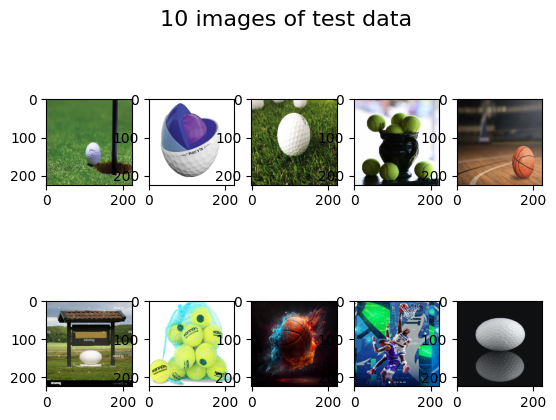

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
golfball
golfball
golfball
golfball
basketball
basketball
tennisball
basketball
basketball
golfball


In [50]:
model = load_model("/content/drive/MyDrive/GeekSalon/技術課題_画像分類/解答例/ballCrastering.h5")
scores = model.evaluate(test_generator, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

X_test, y_test = next(test_generator)

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i])
plt.suptitle("10 images of test data", fontsize=16)
plt.show()

preds = np.argmax(vgg_model.predict(X_test[0:10]), axis=1)
for pred in preds:
  if pred == 0:
    print("basketball")
  elif pred == 1:
    print("golfball")
  else:
    print("tennisball")